In [1]:
# LOADING PACKAGE AND DATA

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
# Check current directory
current_directory = os.getcwd()

# Specify the file path
file_name = "./dataset/tiki1.csv"
file_path = os.path.join(current_directory, file_name)
df = pd.read_csv(file_path)

In [4]:
# Check if there are any null values
print(df.isnull().sum())

Link                 0
Name                 0
Brand                0
Price                0
Sale                 0
Stars               92
NumberOfCoupon     659
5 stars             92
4 stars             92
3 stars             92
2 stars             92
1 star              92
Reviews           1000
dtype: int64


In [5]:
# Check columns to make sure you have features and a target variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Link            1000 non-null   object 
 1   Name            1000 non-null   object 
 2   Brand           1000 non-null   object 
 3   Price           1000 non-null   object 
 4   Sale            1000 non-null   object 
 5   Stars           908 non-null    float64
 6   NumberOfCoupon  341 non-null    float64
 7   5 stars         908 non-null    float64
 8   4 stars         908 non-null    float64
 9   3 stars         908 non-null    float64
 10  2 stars         908 non-null    float64
 11  1 star          908 non-null    float64
 12  Reviews         0 non-null      float64
dtypes: float64(8), object(5)
memory usage: 101.7+ KB


In [6]:
# CLEAN DATA

In [7]:
# List of columns to drop
columns_to_drop = ['Reviews', 'Link', 'Name', 'Brand']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Add Category
df.loc[:199, 'Category'] =  1 #'Dụng cụ nhà bếp'
df.loc[200:399, 'Category'] = 2 #'Trang trí nhà cửa'
df.loc[400:599, 'Category'] = 3 #'Đồ dùng phòng ngủ'
df.loc[600:799, 'Category'] = 4 #'Ngoài trời sân vườn'
df.loc[800:999, 'Category'] = 5 #'Đồ nội thất'

In [9]:
# Impute missing value to specific columns
selected_columns = ['5 stars', '4 stars', '3 stars', '2 stars', '1 star', 'Stars']

# Iterate through selected columns and impute missing values with column means
for column in selected_columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [10]:
# Add 0 to null value in column NumberOfCoupon
df['NumberOfCoupon'].fillna(0, inplace=True)

In [11]:
# Convert numerical data to number (price, stars, sale)
# Convert price to int
df['Price'] = df['Price'].astype(str) # turn object to str
df['Price'] = df['Price'].str.replace(r'\D', '', regex=True).astype(int) # remove character

# Convert sale to int
df['Sale'] = df['Sale'].astype(str) # turn object to str
df['Sale'] = df['Sale'].str.replace(r'\D', '', regex=True).astype(int) # remove character

# Convert the '5 stars', .. '1 star' column to integers only if it's not null,
df[['5 stars', '4 stars', '3 stars', '2 stars', '1 star']] = df[['5 stars', '4 stars', '3 stars', '2 stars', '1 star']].apply(
    lambda x: pd.to_numeric(x, errors='coerce').astype(int)
) 

In [12]:
# Check if there are any null values
print(df.isnull().sum())

# Check columns to make sure you have features and a target variable
print(df)

Price             0
Sale              0
Stars             0
NumberOfCoupon    0
5 stars           0
4 stars           0
3 stars           0
2 stars           0
1 star            0
Category          0
dtype: int64
      Price  Sale     Stars  NumberOfCoupon  5 stars  4 stars  3 stars  \
0    441000  5000  4.600000             5.0      110       20        8   
1    518000  3027  4.500000             5.0       67       18        2   
2    132000  2196  5.000000             0.0        5        0        0   
3    693000  5000  4.600000             5.0      441      110       21   
4    231000  4580  5.000000             5.0      821       71        8   
..      ...   ...       ...             ...      ...      ...      ...   
995  105000    56  4.500000             0.0        4        5        0   
996   45000    98  5.000000             0.0        4        0        0   
997   24900    25  5.000000             4.0        2        0        0   
998  220000    41  4.100000             0.0    

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# DESCRIPTIVE STATISTICS

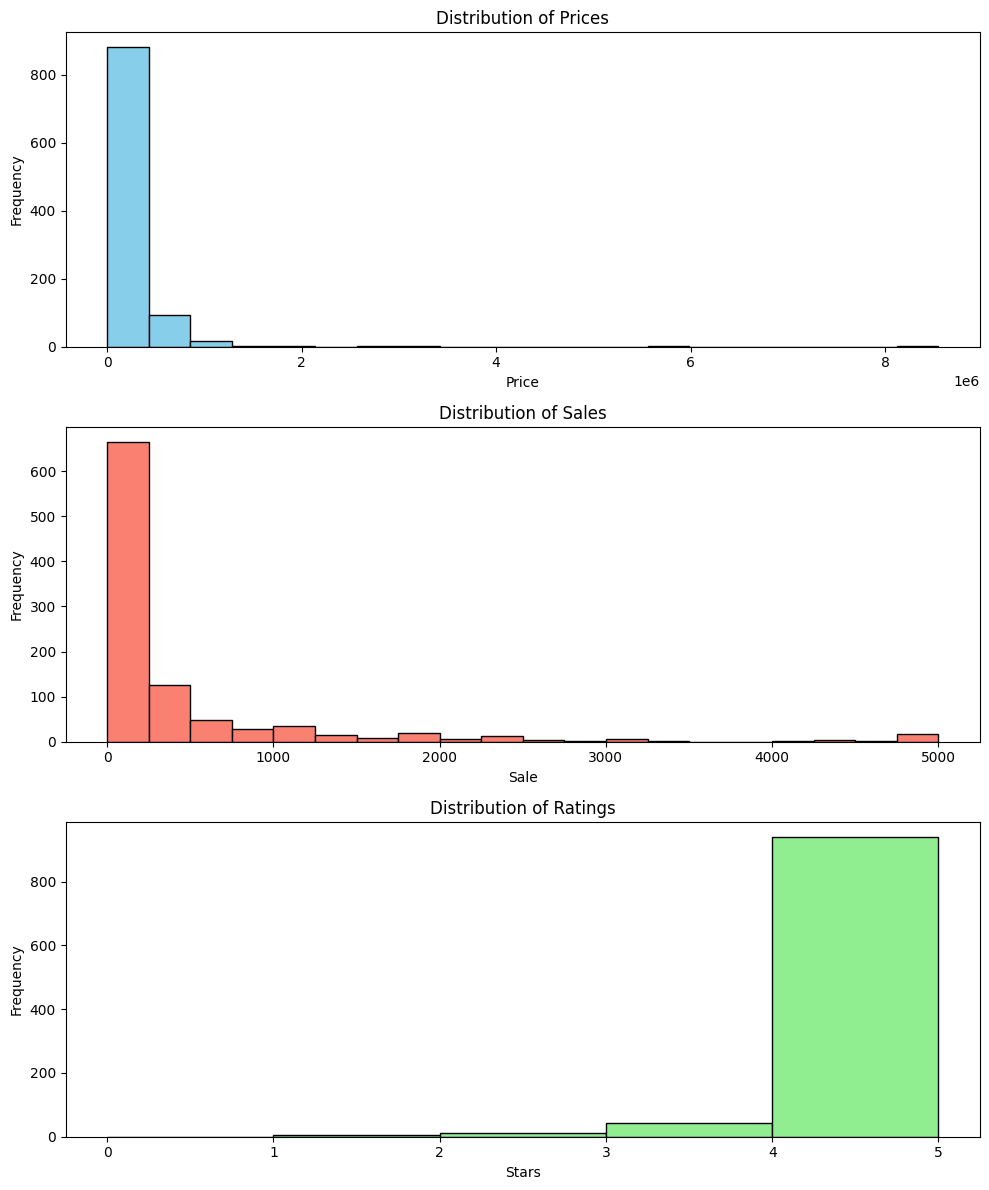

In [15]:
# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Histogram for 'Price'
axes[0].hist(df['Price'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Histogram for 'Sale'
axes[1].hist(df['Sale'].dropna(), bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Sales')
axes[1].set_xlabel('Sale')
axes[1].set_ylabel('Frequency')

# Histogram for 'Stars'
axes[2].hist(df['Stars'].dropna(), bins=5, range=(0, 5), color='lightgreen', edgecolor='black')
axes[2].set_title('Distribution of Ratings')
axes[2].set_xlabel('Stars')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [16]:
# Summary count, mean, std, min, max, 25% quantile, 50% quantile, 75% quantile 
selected_columns = ['Price', 'Sale', 'Stars', 'NumberOfCoupon']

summary_table = df[selected_columns].describe().transpose()

# Display the summary table
print("Summary Statistics:")
print(summary_table)

Summary Statistics:
                 count           mean            std     min      25%  \
Price           1000.0  207014.408000  414736.946722  1000.0  42750.0   
Sale            1000.0     456.473000     883.563560     1.0     41.0   
Stars           1000.0       4.563767       0.505464     1.0      4.5   
NumberOfCoupon  1000.0       1.189000       2.039961     0.0      0.0   

                     50%       75%        max  
Price           110000.0  229625.0  8549000.0  
Sale               126.0     407.0     5000.0  
Stars                4.6       4.8        5.0  
NumberOfCoupon       0.0       2.0       17.0  


In [17]:
What is the percentage of sale for each category?
What is the total sales for each category?

Object `category` not found.
Object `category` not found.


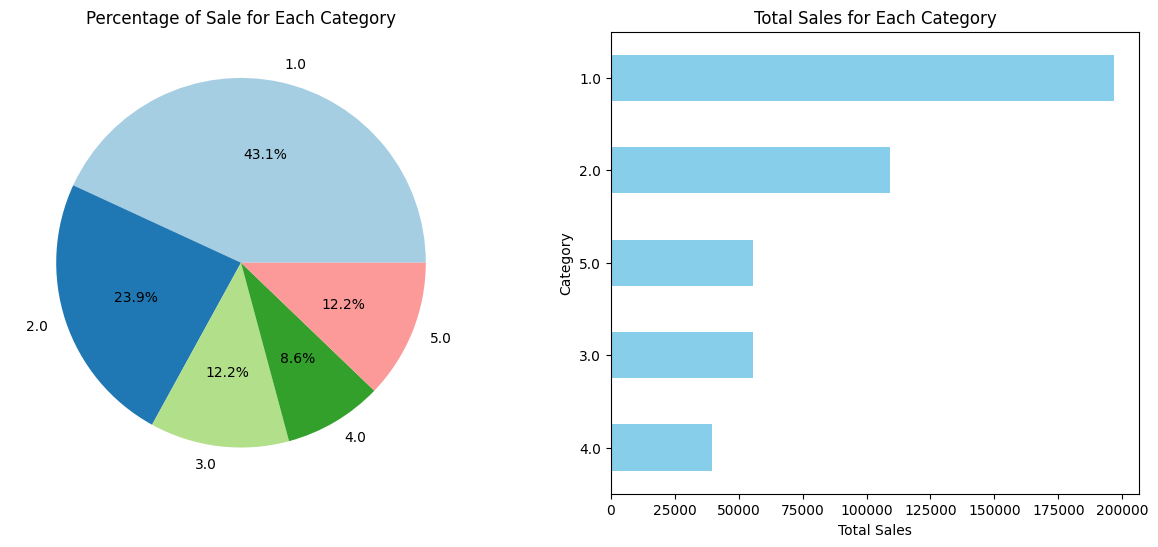

In [18]:
df['Sale'] = pd.to_numeric(df['Sale'], errors='coerce')  # Convert 'Sale' column to numeric

# Group by 'Category' and calculate the sum of sales for each category
category_sales = df.groupby('Category')['Sale'].sum()

# Calculate the total sale for all categories
total_sale = category_sales.sum()

# Calculate the percentage of sale for each category
percentage_sale = (category_sales / total_sale) * 100

# Plot the pie chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Pie chart
axes[0].pie(percentage_sale, labels=percentage_sale.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set_title('Percentage of Sale for Each Category')
axes[0].set_ylabel('')  # Remove the default 'Category' label

# Bar chart
category_sales.sort_values().plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Total Sales for Each Category')
axes[1].set_xlabel('Total Sales')

plt.show()

In [19]:
# STATISTICAL CALCULATIONS

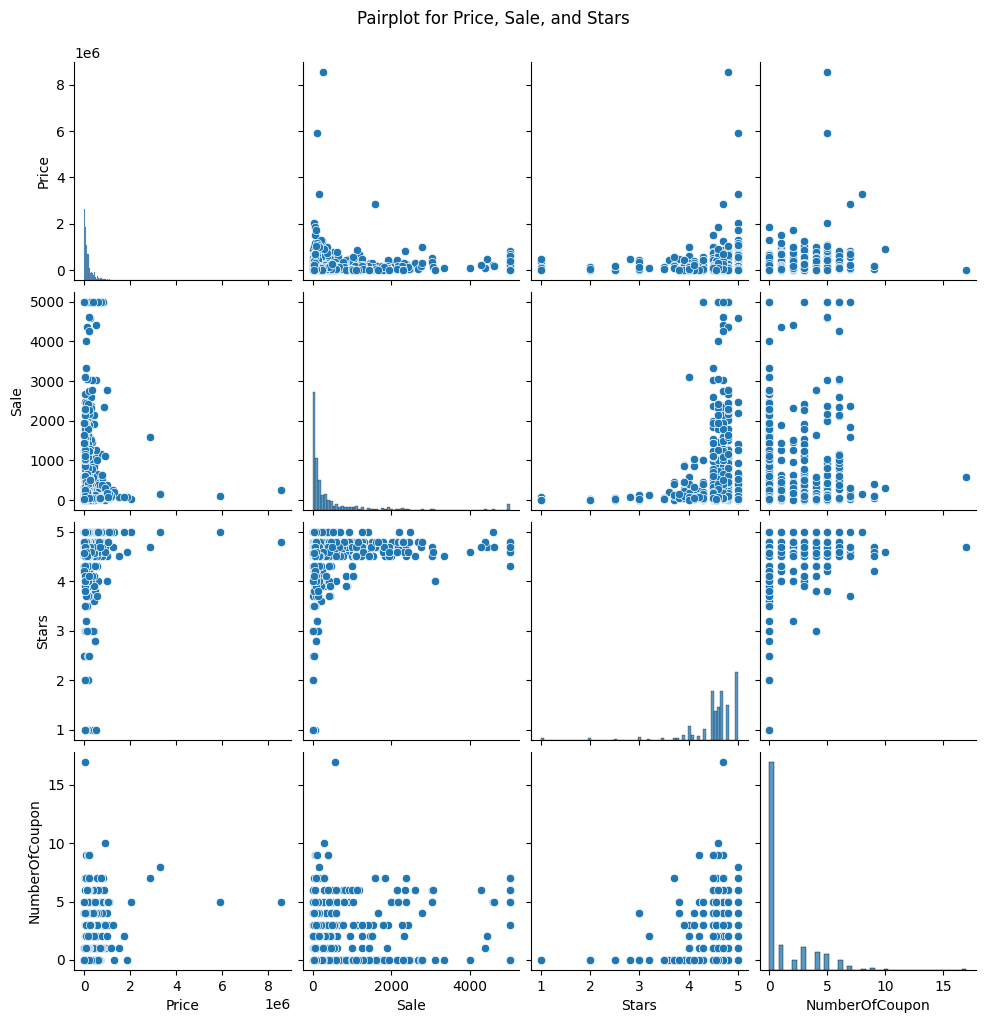

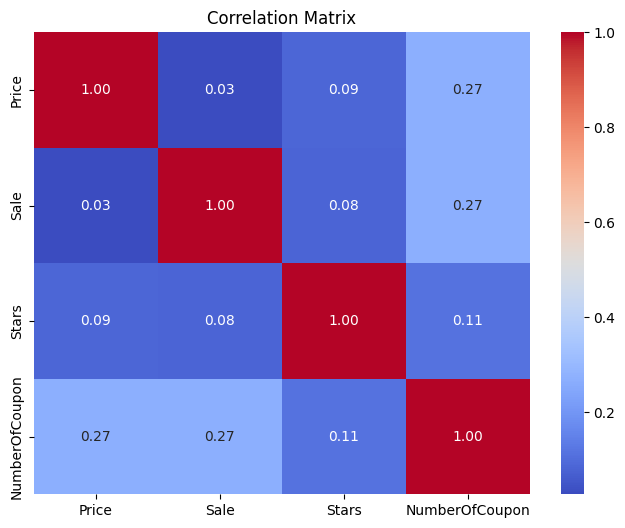

In [20]:
# Correlations: Check correlations between variables like 'Price', 'Sale', 'Stars', and 'Reviews' to understand relationships
sns.pairplot(df[selected_columns].dropna())
plt.suptitle("Pairplot for Price, Sale, and Stars", y=1.02)
plt.show()

# Correlation matrix
correlation_matrix = df[selected_columns].corr()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [21]:
import numpy as np
from collections import Counter
import random

In [25]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # Will store individually trained decision trees
        self.decision_trees = []
        
    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]
        
    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.
        
        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []
            
        # Build each tree of the forest
        num_built = 0
        print(self.num_trees)
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split=self.min_samples_split,
                    max_depth=self.max_depth
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
                print(num_built)
            except Exception as e:
                continue
    
    def predict(self, X):
        '''
        Predicts class labels for new data instances.
        
        :param X: np.array, new instances to predict
        :return: 
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))
        
        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)
        
        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = Counter(preds)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

In [26]:
from sklearn.model_selection import train_test_split
X = df[['Price', 'Stars', 'NumberOfCoupon', '5 stars', '4 stars', '3 stars', '2 stars', '1 star', 'Category']]
y = df['Sale']
X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# clf = RandomForest(n_trees=20, max_depth=20)

# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# acc = accuracy(y_test, y_pred)

# print("Accuracy:", acc)

model = RandomForest()
model.fit(X_train, y_train)
preds = model.predict(X_test)

25
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
np.array(preds, dtype=np.int64)

In [ ]:
np.array(y_test, dtype=np.int64)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, preds)
print("R^2 Score:", r2)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(y_test, preds)
print("Mean Absolute Error:", mae)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are your training and testing data

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
predictions = rf_model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)